**Set up Env & Import raw data**

In [1]:
import numpy as np 
import pandas as pd 
!pip install gdown

In [2]:
# List folder for demo
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# List GPUs
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [4]:

import gdown

!gdown --id 1nHU1ZQ82sH2OvbBPZkORtz3OMPZ8iei6
!gdown --id 1shhfoE5RBhbvfAA8FmyKzPi9NqmQWqUT
!gdown --id 1_Z7DMmdBec_KQUY7tvw8Ie5igoucwWAM
!gdown --id 1mNvYsKCvZ1swPmGpqQYuVG8vctXE6C-1
!unzip "/kaggle/working/DIFOT Result Full from May23 to Aug24 - Copy.zip" -d /kaggle/working/

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nHU1ZQ82sH2OvbBPZkORtz3OMPZ8iei6
From (redirected): https://drive.google.com/uc?id=1nHU1ZQ82sH2OvbBPZkORtz3OMPZ8iei6&confirm=t&uuid=95585c5a-8764-49aa-91eb-3f839ce29864
To: /kaggle/working/DIFOT Result Full from May23 to Aug24 - Copy.zip
100%|██████████████████████████████████████| 1.91G/1.91G [00:19<00:00, 98.3MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1shhfoE5RBhbvfAA8FmyKzPi9NqmQWqUT
To: /kaggle/working/GPS 2nd customer.csv
100%|███████████████████████████████████████| 47

In [5]:
# Set up spark context


!pip install pyspark==3.0.1 py4j==0.10.9
import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "1000")\
    .getOrCreate()

import logging


# Set logging level to ERROR to suppress WARN messages
logger = spark._jvm.org.apache.log4j
logger.LogManager.getRootLogger().setLevel(logger.Level.ERROR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612223 sha256=04c278bd14735695c35b3213f4b66204e8fb85af1f9b85fe6f997b56f9c3c626
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


24/09/05 19:00:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
#Import table factdata show transaction of sales register & sales order  


from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col,to_date

factdata= spark.read.csv('/kaggle/working/DIFOT Result Full from May23 to Aug24 - Copy.csv')
header = factdata.first()
# Remove the first row from the DataFrame
factdata = factdata.filter(col("`_c0`") != header._c0) # Assuming _c0 is not null in the header
# Create a list of column names from the header row
columns = [header[i] for i in range(len(header))]
# Rename columns in the DataFrame
factdata = factdata.select([col(f"`_c{i}`").alias(name) for i, name in enumerate(columns)])

factdata = factdata.withColumn('order_date', to_date(col('order_date'), 'dd-MM-yyyy')) # Định dạng mẫu ví dụ
factdata = factdata.withColumn('settlement_date', to_date(col('settlement_date'), 'dd-MM-yyyy')) # Định dạng mẫu ví dụ
factdata= factdata.withColumn('totalec_sr', col('totalec_sr').cast(DoubleType()))
factdata= factdata.withColumn('totalNSR_sr', col('totalNSR_sr').cast(DoubleType()))
factdata= factdata.withColumn('totalNSR_so', col('totalNSR_so').cast(DoubleType()))
factdata= factdata.withColumn('totalec_so', col('totalec_so').cast(DoubleType()))
factdata= factdata.withColumn('diff_ec', col('diff_ec').cast(DoubleType()))
factdata= factdata.withColumn('diff_NSR', col('diff_NSR').cast(DoubleType()))
factdata.show(1)
factdata.printSchema()




+----------+---------------+-----------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+
|order_date|settlement_date|           region|distributor_code|customer_code|segmentation|channelname|    order_no|item_code| brand|pack_type|pack_size|              key_so|totalec_sr|totalNSR_sr|totalNSR_so|totalec_so|diff_ec|diff_NSR|
+----------+---------------+-----------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+
|2023-06-08|     2023-06-08|North East Region|      0070000004|   0070435473|    DRINKING|     Bronze|000031112878|     2710|Dasani|      PET|    350ML|08-06-2023-000031...|     0.125|     8250.0|     8250.0|     0.125|    0.0|     0.0|
+----------+---------------+-----------------+------

In [7]:
#Import GPS tables show location of distributor & customer  

from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

#

GPScus=spark.read.csv('/kaggle/working/GPS 2nd customer.csv')
header1 = GPScus.first()
GPScus = GPScus.filter(col("`_c0`") != header1._c0)
columns = [header1[i] for i in range(len(header1))]
GPScus = GPScus.select([col(f"`_c{i}`").alias(name) for i, name in enumerate(columns)])
#GPScus.show()
GPScus = GPScus.withColumn('latitude', col('latitude').cast(DoubleType()))
GPScus = GPScus.withColumn('longitude', col('longitude').cast(DoubleType()))
GPScus.show(5)
GPScus.printSchema()

#
 
GPSdist=spark.read.csv('/kaggle/working/GPS Distributor.csv')
header2 = GPSdist.first()
GPSdist = GPSdist.filter(col("`_c0`") != header2._c0)
columns = [header2[i] for i in range(len(header2))]
GPSdist = GPSdist.select([col(f"`_c{i}`").alias(name) for i, name in enumerate(columns)])
GPSdist = GPSdist.withColumn('latitude', col('latitude').cast(DoubleType()))
GPSdist = GPSdist.withColumn('longitude', col('longitude').cast(DoubleType()))
GPSdist.show(5)
GPSdist.printSchema()

#

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import to_date, col

Listdayoff=spark.read.csv('/kaggle/working/List Day off .csv')
header3 = Listdayoff.first()
Listdayoff = Listdayoff.filter(col("`_c0`") != header3._c0)
columns = [header3[i] for i in range(len(header3))]
Listdayoff = Listdayoff.select([col(f"`_c{i}`").alias(name) for i, name in enumerate(columns)])

Listdayoff = Listdayoff.withColumn("d_date", to_date(col("d_date"), 'dd-MMM-yy'))
Listdayoff = Listdayoff.withColumn("eoweek KO", to_date(col("eoweek KO"), 'dd-MMM-yy'))
Listdayoff = Listdayoff.withColumn("eomonth KO", to_date(col("eomonth KO"), 'dd-MMM-yy'))
Listdayoff= Listdayoff.withColumn('year', col('year').cast(DoubleType()))

Listdayoff.show(2)

Listdayoff.printSchema()

+----------+---------+----------+
|customerid| latitude| longitude|
+----------+---------+----------+
|0070000973|15.879528|108.320436|
|0070002090|15.887124|108.333909|
|0070005507|      3.0|       0.0|
|0070000112|      0.0|       0.0|
|0070007208|16.081088|108.211983|
+----------+---------+----------+
only showing top 5 rows

root
 |-- customerid: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+----------+---------+----------+
|customerid| latitude| longitude|
+----------+---------+----------+
|0070000112|      0.0|       0.0|
|0070029284|      0.0|       0.0|
|0070029536|      0.0|       0.0|
|0070034943|21.020614|105.901715|
|0070033287|      0.0|       0.0|
+----------+---------+----------+
only showing top 5 rows

root
 |-- customerid: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+----------+------+-------+----------+----------+-----------+
|    d_date|  year

**Calculate Variable**

**Var Distance Km (Delivery Distance from Distributor to Customer)**

In [9]:
#1.Left join to get GPS location for Factdata table

from pyspark.sql.functions import col

# Join factdata and GPScus
factdata_with_GPScus = factdata.join(GPScus.alias('GPScus'), factdata.customer_code == GPScus.customerid, "left")


# Join factdata_with_GPScus and GPSdist
final_df = factdata_with_GPScus.join(GPSdist.alias('GPSdist'), factdata_with_GPScus.distributor_code == GPSdist.customerid, "left")

# Select col from DataFrame 
final_df = final_df.select(
    'order_date',
    'settlement_date',
    'region',
    'distributor_code',
    'customer_code',
    'segmentation',
    'channelname',
    'order_no',
    'item_code',
    'brand',
    'pack_type',
    'pack_size',
    'key_so',
    'totalec_sr',
    'totalNSR_sr',
    'totalNSR_so',
    'totalec_so',
    'diff_ec',
    'diff_NSR',
    col('GPScus.latitude').alias('GPScuslatitude'),
    col('GPScus.longitude').alias('GPScuslongitude'),
    col('GPSdist.latitude').alias('GPSdistlatitude'),
    col('GPSdist.longitude').alias('GPSdistlongitude')
)
#final_df.show()
print(final_df.columns)


#2.Calculate distance_km: Delivery Distance from Distributor (GPSdist) to Customer(GPScus)

import math
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def haversine(lat1, lon1, lat2, lon2):
    # convert radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of the Earth (km)
    return r * c

# Create UDF from function haversine
haversine_udf = udf(haversine, DoubleType())

final_df_with_distance = final_df.withColumn(
    'distance_km',
    haversine_udf(
        col('GPScuslatitude'),
        col('GPScuslongitude'),
        col('GPSdistlatitude'),
        col('GPSdistlongitude')
    )
)
# View DataFrame with distance_km col

print(final_df_with_distance.columns)




['order_date', 'settlement_date', 'region', 'distributor_code', 'customer_code', 'segmentation', 'channelname', 'order_no', 'item_code', 'brand', 'pack_type', 'pack_size', 'key_so', 'totalec_sr', 'totalNSR_sr', 'totalNSR_so', 'totalec_so', 'diff_ec', 'diff_NSR', 'GPScuslatitude', 'GPScuslongitude', 'GPSdistlatitude', 'GPSdistlongitude']
['order_date', 'settlement_date', 'region', 'distributor_code', 'customer_code', 'segmentation', 'channelname', 'order_no', 'item_code', 'brand', 'pack_type', 'pack_size', 'key_so', 'totalec_sr', 'totalNSR_sr', 'totalNSR_so', 'totalec_so', 'diff_ec', 'diff_NSR', 'GPScuslatitude', 'GPScuslongitude', 'GPSdistlatitude', 'GPSdistlongitude', 'distance_km']


+----------+---------------+---------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+--------------+---------------+---------------+----------------+-----------------+
|order_date|settlement_date|         region|distributor_code|customer_code|segmentation|channelname|    order_no|item_code| brand|pack_type|pack_size|              key_so|totalec_sr|totalNSR_sr|totalNSR_so|totalec_so|diff_ec|diff_NSR|GPScuslatitude|GPScuslongitude|GPSdistlatitude|GPSdistlongitude|      distance_km|
+----------+---------------+---------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+--------------+---------------+---------------+----------------+-----------------+
|2023-09-28|     2023-09-29|Central  Region|     

**Fill NA of distance_km variable**

In [10]:

#3.Data processing GPS is Null and 0


#3.1 Filter GPS is Null and GPS=0
from pyspark.sql.functions import concat, lit, avg, col, when

final_df_with_distance.cache()
final_df_with_distance_notnull=final_df_with_distance.filter(
    (col("GPScuslatitude").isNotNull()) & (col("GPScuslongitude").isNotNull()) & 
    (col("GPSdistlatitude") != 0) & (col("GPSdistlongitude") != 0)
)   

final_df_with_distance_notnull.printSchema()


root
 |-- order_date: date (nullable = true)
 |-- settlement_date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- distributor_code: string (nullable = true)
 |-- customer_code: string (nullable = true)
 |-- segmentation: string (nullable = true)
 |-- channelname: string (nullable = true)
 |-- order_no: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- pack_type: string (nullable = true)
 |-- pack_size: string (nullable = true)
 |-- key_so: string (nullable = true)
 |-- totalec_sr: double (nullable = true)
 |-- totalNSR_sr: double (nullable = true)
 |-- totalNSR_so: double (nullable = true)
 |-- totalec_so: double (nullable = true)
 |-- diff_ec: double (nullable = true)
 |-- diff_NSR: double (nullable = true)
 |-- GPScuslatitude: double (nullable = true)
 |-- GPScuslongitude: double (nullable = true)
 |-- GPSdistlatitude: double (nullable = true)
 |-- GPSdistlongitude: double (nullable = true)
 |-- distance_km:

In [11]:
#3.2 Calculate median of distance_km column

from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, count

# Create a Window specification to order by 'distance_km'

window_spec = Window.orderBy(col("distance_km"))

final_df_with_distance_notnull=final_df_with_distance_notnull.cache()

# Add a row number column
df_with_row_number = final_df_with_distance_notnull.withColumn("row_number", row_number().over(window_spec)).cache()

# Count the total number of rows

total_count = final_df_with_distance_notnull.count()

# Calculate the median position

median_position = (total_count + 1) // 2

# Get the median value

median_df = df_with_row_number.filter(col("row_number") == median_position).select("distance_km")

# In case of even number of rows, compute the average of the two middle values

if total_count % 2 == 0:
   median_position_2 = median_position + 1
   median_df_2 = df_with_row_number.filter(col("row_number") == median_position_2).select("distance_km")
   median_value = (median_df.collect()[0][0] + median_df_2.collect()[0][0]) / 2
else:
   median_value = median_df.collect()[0][0]

print(f"median_distance_km: {median_value}")
#median_distance_km = 5.881606785112515

In [12]:
#Fill Missing Value equal median


median_distance_km = 5.881606785112515

from pyspark.sql.functions import when

condition = (
    (col('GPScuslatitude') == 0) |
    (col('GPScuslongitude') == 0) |
    (col('GPSdistlatitude') == 0) |
    (col('GPSdistlongitude') == 0) |
    col('distance_km').isNull() |
    (col('distance_km') == 'N/A')
)


# Apply the condition to fill the distance_km column
final_df_with_distance=final_df_with_distance.cache()
final_df_filled = final_df_with_distance.withColumn(
    'distance_km',
    when(condition, median_distance_km).otherwise(col('distance_km'))
)

final_df_filled = final_df_filled.withColumn('order_date', to_date(col('order_date'), 'MM-dd-yyyy')) # Định dạng mẫu ví dụ
final_df_filled = final_df_filled.withColumn('settlement_date', to_date(col('settlement_date'), 'MM-dd-yyyy')) # Định dạng mẫu ví dụ

# Verify the results
final_df_filled.show(1)

+----------+---------------+---------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+--------------+---------------+---------------+----------------+-----------------+
|order_date|settlement_date|         region|distributor_code|customer_code|segmentation|channelname|    order_no|item_code| brand|pack_type|pack_size|              key_so|totalec_sr|totalNSR_sr|totalNSR_so|totalec_so|diff_ec|diff_NSR|GPScuslatitude|GPScuslongitude|GPSdistlatitude|GPSdistlongitude|      distance_km|
+----------+---------------+---------------+----------------+-------------+------------+-----------+------------+---------+------+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+--------------+---------------+---------------+----------------+-----------------+
|2023-09-28|     2023-09-29|Central  Region|     

**Remove outlier of distance variance**

In [13]:
#Normality test to choose Remove Outlier Method (IQR/STD)

sample_df = final_df_filled.sample(fraction=0.3)

# Convert to Pandas
data_pd = sample_df.select("distance_km").toPandas()['distance_km']

# Normality test
from scipy.stats import shapiro
stat, p_value = shapiro(data_pd)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}")

#Conclude final_df_filled "distance_km" does not follow a normal distribution


In [14]:
#Remove outliers using IQR method

from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Spark session
spark = SparkSession.builder.appName("OutlierDetection").getOrCreate()

# Calculate (Q1 và Q3) and IQR
# Using approxQuantile
quantiles = final_df_filled.approxQuantile("distance_km", [0.25, 0.75], 0.01)

Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# Calculate bound outlier
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Remove outliers
filtered_outliers_df = final_df_filled.filter(
    (col('distance_km') >= lower_bound) & (col('distance_km') <= upper_bound)
)

# Bước 4: Checking remaining data
total_rows = final_df_filled.count()
filtered_rows = filtered_outliers_df.count()
remaining_data_percentage = (filtered_rows / total_rows) * 100

print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Remaining Data Percentage: {remaining_data_percentage:.2f}%")
 

IQR: 8.174997098652394
Lower Bound: -13.698611900619364
Upper Bound: 27.176373592642605
Remaining Data Percentage: 90.82%


**Visualize Distance_km variable**

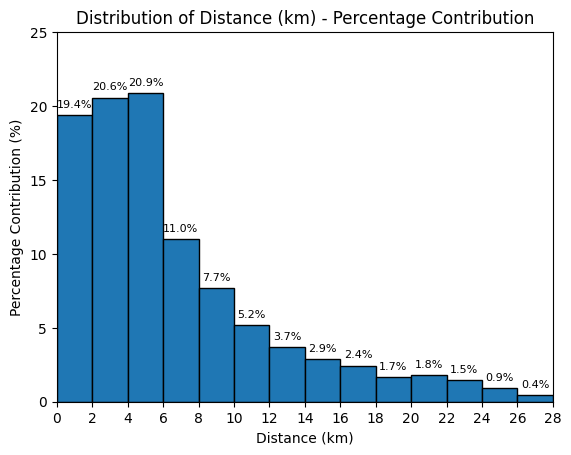

In [15]:
import matplotlib.pyplot as plt

# Step 1: Compute histogram in Spark using the specified bin edges
bin_edges = list(range(0, 30, 2))  # Adjusted to include 30 as the last bin edge
hist_data = filtered_outliers_df.select('distance_km').rdd.flatMap(lambda x: x).histogram(bin_edges)

# Extract bin edges and frequencies
frequencies = hist_data[1]
bin_edges = hist_data[0]

# Convert frequencies to percentage contribution
total = sum(frequencies)
percentages = [(freq / total) * 100 for freq in frequencies]

# Step 2: Plot the histogram with percentage contribution
plt.bar(bin_edges[:-1], percentages, width=2, edgecolor='black', align='edge')

# Add percentage labels on top of each bar
for i in range(len(percentages)):
    plt.text(bin_edges[i]+1, percentages[i] + 0.5, f'{percentages[i]:.1f}%', ha='center', fontsize=8)

plt.xlabel('Distance (km)')
plt.ylabel('Percentage Contribution (%)')
plt.title('Distribution of Distance (km) - Percentage Contribution')
plt.xticks(bin_edges)  # Set x-axis ticks to match bin edges

# Limit x-axis to 0 to 30
plt.xlim(0, 28)
plt.ylim(0, 25)
plt.xticks(bin_edges) 
#plt.show()


import pandas as pd

# Prepare data for tabular format
table_data = {
    'Distance (Km)': [f'{start}-{end}' for start, end in zip(bin_edges[:-1], bin_edges[1:])],
    'Frequency': [f'{freq:,}' for freq in frequencies],
    'Percentage Contribution (%)': [f'{round(pct, 1)}%' for pct in percentages]
}

# Create DataFrame
table_df = pd.DataFrame(table_data)

# Remove rows where 'Distance (Km)' is '28-30'
table_df = table_df[table_df['Distance (Km)'] != '28-30']

# Display the table with borders and no index
print(table_df.to_string(index=False, formatters={'Frequency': '{:<}'.format, 'Percentage Contribution (%)': '{:<}'.format}))


**Delivery Time Variable**

In [16]:

from pyspark.sql.functions import col, datediff

filtered_outliers_df = filtered_outliers_df.withColumn(
    "DeliveryDay", datediff(col("settlement_date"), col("order_date"))
)

filtered_outliers_df = filtered_outliers_df.withColumn(
  "DeliveryDay", col("DeliveryDay").cast("double")
)

filtered_outliers_df.printSchema()

root
 |-- order_date: date (nullable = true)
 |-- settlement_date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- distributor_code: string (nullable = true)
 |-- customer_code: string (nullable = true)
 |-- segmentation: string (nullable = true)
 |-- channelname: string (nullable = true)
 |-- order_no: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- pack_type: string (nullable = true)
 |-- pack_size: string (nullable = true)
 |-- key_so: string (nullable = true)
 |-- totalec_sr: double (nullable = true)
 |-- totalNSR_sr: double (nullable = true)
 |-- totalNSR_so: double (nullable = true)
 |-- totalec_so: double (nullable = true)
 |-- diff_ec: double (nullable = true)
 |-- diff_NSR: double (nullable = true)
 |-- GPScuslatitude: double (nullable = true)
 |-- GPScuslongitude: double (nullable = true)
 |-- GPSdistlatitude: double (nullable = true)
 |-- GPSdistlongitude: double (nullable = true)
 |-- distance_km:

**Ontime when DeliveryDay <= 2 (exclude day off)**

In [17]:
from pyspark.sql.functions import col, countDistinct, concat, lit, when, coalesce
from pyspark.sql import functions as F

# Step 1: Perform a left join between the two DataFrames based on the date range condition
joined_df = filtered_outliers_df.join(
    Listdayoff,
    (col("d_date") >= col("order_date")) & (col("d_date") <= col("settlement_date")),
    "left"
)

# Step 2: Create a new key by concatenating "order_date", "order_no", "settlement_date", and "customer_code" and group by this key
days_off_count_df = joined_df.withColumn(
    "order_key", concat(col("order_date").cast("string"), lit('-'), col("order_no"), lit('-'), col("settlement_date"), lit('-'), col("customer_code"))
).groupBy("order_key").agg(
    countDistinct("d_date").alias("days_off_count")
)

filtered_outliers_df.printSchema()
days_off_count_df.printSchema()

# Step 3: Join this result back to the original DataFrame using the new key and calculate Dayprocessing
filtered_outliers_df = filtered_outliers_df.withColumn(
    "order_key", concat(col("order_date").cast("string"), lit('-'), col("order_no"), lit('-'), col("settlement_date"), lit('-'), col("customer_code"))
).join(
    days_off_count_df, "order_key", "left"
).withColumn(
    "days_off_count", coalesce(days_off_count_df["days_off_count"], lit(0))
).withColumn(
    "Dayprocessing", when(col("DeliveryDay") - col("days_off_count") < 0, lit(0))
                    .otherwise(col("DeliveryDay") - col("days_off_count"))
)

# Create 'Ontime'column
filtered_outliers_df = filtered_outliers_df.withColumn(
    "Ontime", when(col("Dayprocessing") <= 2, "Yes").otherwise("No")
)

# Show the resulting DataFrame with the new column
filtered_outliers_df.show(1)

# Print the schema of the resulting DataFrame
filtered_outliers_df.printSchema()


root
 |-- order_date: date (nullable = true)
 |-- settlement_date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- distributor_code: string (nullable = true)
 |-- customer_code: string (nullable = true)
 |-- segmentation: string (nullable = true)
 |-- channelname: string (nullable = true)
 |-- order_no: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- pack_type: string (nullable = true)
 |-- pack_size: string (nullable = true)
 |-- key_so: string (nullable = true)
 |-- totalec_sr: double (nullable = true)
 |-- totalNSR_sr: double (nullable = true)
 |-- totalNSR_so: double (nullable = true)
 |-- totalec_so: double (nullable = true)
 |-- diff_ec: double (nullable = true)
 |-- diff_NSR: double (nullable = true)
 |-- GPScuslatitude: double (nullable = true)
 |-- GPScuslongitude: double (nullable = true)
 |-- GPSdistlatitude: double (nullable = true)
 |-- GPSdistlongitude: double (nullable = true)
 |-- distance_km:

+--------------------+----------+---------------+-----------------+----------------+-------------+------------+-----------+------------+---------+-----+---------+---------+--------------------+----------+-----------+-----------+----------+-------+--------+--------------+---------------+---------------+----------------+-----------------+-----------+--------------+-------------+------+
|           order_key|order_date|settlement_date|           region|distributor_code|customer_code|segmentation|channelname|    order_no|item_code|brand|pack_type|pack_size|              key_so|totalec_sr|totalNSR_sr|totalNSR_so|totalec_so|diff_ec|diff_NSR|GPScuslatitude|GPScuslongitude|GPSdistlatitude|GPSdistlongitude|      distance_km|DeliveryDay|days_off_count|Dayprocessing|Ontime|
+--------------------+----------+---------------+-----------------+----------------+-------------+------------+-----------+------------+---------+-----+---------+---------+--------------------+----------+-----------+----------

**INFULL & DIFOT Variable** 

In [18]:
filtered_outliers_df.cache()
filtered_outliers_df = filtered_outliers_df.withColumn(
    "Infull", when(col("diff_ec") <= 0.1, "Yes").otherwise("No")
)
filtered_outliers_df = filtered_outliers_df.withColumn(
    "DIFOT", when((col("Infull") == "Yes") & (col("Ontime") == "Yes"), "Yes").otherwise("No")
)

filtered_outliers_df.printSchema()


root
 |-- order_key: string (nullable = true)
 |-- order_date: date (nullable = true)
 |-- settlement_date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- distributor_code: string (nullable = true)
 |-- customer_code: string (nullable = true)
 |-- segmentation: string (nullable = true)
 |-- channelname: string (nullable = true)
 |-- order_no: string (nullable = true)
 |-- item_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- pack_type: string (nullable = true)
 |-- pack_size: string (nullable = true)
 |-- key_so: string (nullable = true)
 |-- totalec_sr: double (nullable = true)
 |-- totalNSR_sr: double (nullable = true)
 |-- totalNSR_so: double (nullable = true)
 |-- totalec_so: double (nullable = true)
 |-- diff_ec: double (nullable = true)
 |-- diff_NSR: double (nullable = true)
 |-- GPScuslatitude: double (nullable = true)
 |-- GPScuslongitude: double (nullable = true)
 |-- GPSdistlatitude: double (nullable = true)
 |-- GPSdistlongitude: d

In [21]:
filtered_outliers_df.cache()

# Step 2: Specify the output path for compressed CSV (gzip)
output_path = "/kaggle/working/datafortrainingmodel.csv.gz"

# Step 3: Write the DataFrame to a compressed CSV file using gzip
filtered_outliers_df.write.csv(output_path, header=True, mode='overwrite', compression='gzip')






**Export data frame after Processing**

In [22]:
import zipfile
import os

# Thư mục chứa các file .gz
source_dir = "/kaggle/working/"
# Đường dẫn file zip bạn muốn tạo
zip_file_path = "/kaggle/working/datafortrainingmodel.zip"

# Tạo một file .zip và thêm các file .gz vào
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Duyệt tất cả các file trong thư mục
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith('.gz'):
                file_path = os.path.join(root, file)
                # Thêm file vào zip với tên file gốc
                zipf.write(file_path, os.path.basename(file_path))


In [ ]:
import os -> os.chdir(r'/kaggle/working/datafortrainingmodel.zip')
from IPython.display import FileLink -> FileLink(r'/kaggle/working/datafortrainingmodel.zip')
